<a href="https://colab.research.google.com/github/jremsza/NLP_project/blob/main/MSDS453_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 46.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [2]:
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.manifold import MDS


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

import pandas as pd
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora


from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from wordcloud import WordCloud
from collections import Counter
from collections import defaultdict

In [3]:
import nltk # Import the nltk library
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
# import pandas as pd
# import random

# # File paths
# input_file = "train.ft.txt"  # Update this with your actual file path
# output_file = "review_subset.csv"
# sample_fraction = 0.01  # 1% sample

# # Read and sample the file efficiently
# sampled_lines = []
# with open(input_file, "r", encoding="utf-8") as file:
#     for line in file:
#         if random.random() < sample_fraction:  # 10% chance to keep the line
#             sampled_lines.append(line.strip())

# # Process the sampled lines into a structured DataFrame
# processed_data = []
# for line in sampled_lines:
#     label, text = line.split(" ", 1)  # Split into label and text
#     label = label.replace("__label__", "")  # Remove prefix
#     processed_data.append([label, text])

# # Convert to DataFrame
# df = pd.DataFrame(processed_data, columns=["label", "review"])

# # Save to CSV
# df.to_csv(output_file, index=False, encoding="utf-8")

# print(f"Saved {len(df)} sampled reviews to {output_file}")

### Load The Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
with open('/content/drive/My Drive/DS-453/review_subset.csv', 'r') as file:
  text = file.read()

### Clean Document

In [7]:
def clean_doc(doc, remove_stopwords=True, use_stemming=False, use_lemmatization=False, handle_ec=False, EC_MAPPING=None):
    tokens = doc.split()

    # Remove punctuation
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', word) for word in tokens]

    # Remove non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]

    # Equivalence Class (EC) Mapping
    if handle_ec and EC_MAPPING:
        tokens = [EC_MAPPING[word] if word in EC_MAPPING else word for word in tokens]

    # Lowercase words
    tokens = [word.lower() for word in tokens]

    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    if use_stemming:
        ps = PorterStemmer()
        tokens = [ps.stem(word) for word in tokens]

    # Lemmatization
    if use_lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

In [8]:
df = pd.read_csv('/content/drive/My Drive/DS-453/review_subset.csv')


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36077 entries, 0 to 36076
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   36077 non-null  int64 
 1   review  36077 non-null  object
dtypes: int64(1), object(1)
memory usage: 563.8+ KB


In [10]:
df.head(10)

label                                             review
0      1  Disappointing: The text is the same as ever (I...
1      1  Title is a Scam: When someone is intentionally...
2      1  Burn Rubber on Me: I went by the Squeem chart ...
3      1  Fall apart: I don't understand why these inser...
4      1  it was very slow.: Hawthorne was a excellent w...
5      2  Best one in Tomato Trilogy: Return of the Kill...
6      2  Get off the dead horse of "old school" educati...
7      1  Only lasts 6 months: I bought this power adapt...
8      2  "Super" fun: Rated for 3+ but my 2 and 3 yr. o...
9      2  Florida birds: I love my nature guide to Flori...

In [11]:
label_counts = df['label'].value_counts()

Label Distribution:
 label
2    18062
1    18015
Name: count, dtype: int64


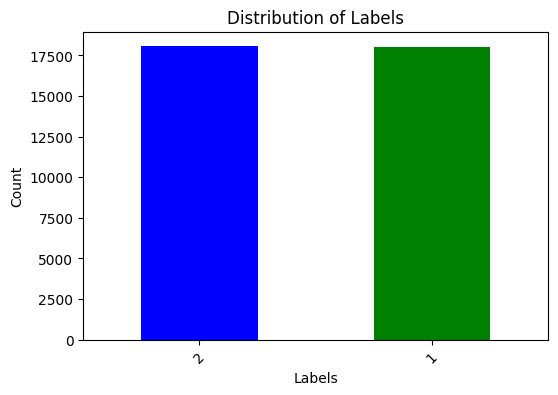

In [12]:
# Print label distribution
print("Label Distribution:\n", label_counts)

# Plot bar chart
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', color=['blue', 'green'])
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.xticks(rotation=45)
plt.show()


In [13]:
processed_text = df["review"].apply(lambda x: clean_doc(x, remove_stopwords=True, use_stemming=False, use_lemmatization=False, handle_ec=False))

<ipython-input-14-0e11474d4bd6>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=common_df, palette='Blues_r')


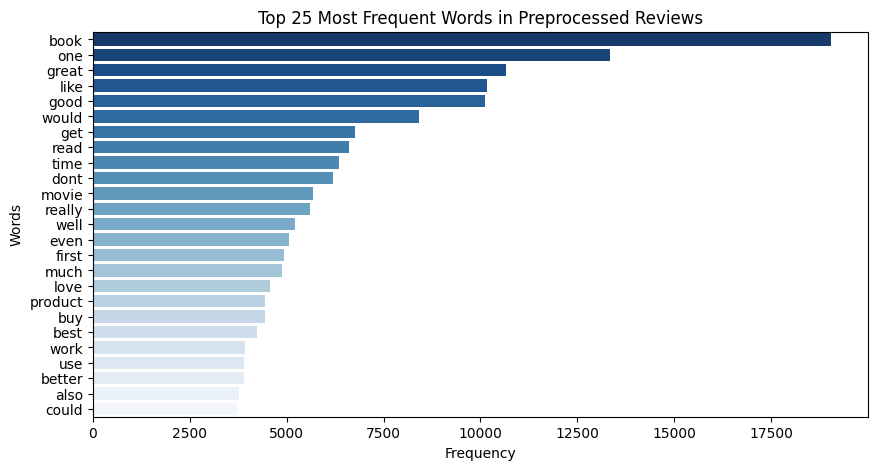

In [14]:
# Bar chart of top 25 most frequent words

all_words = []
for text in processed_text:
  all_words.extend(text.split())

word_counts = Counter(all_words)
common_words = word_counts.most_common(25)

# Convert to DataFrame for plotting
common_df = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Plot bar chart
plt.figure(figsize=(10,5))
sns.barplot(x='Count', y='Word', data=common_df, palette='Blues_r')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 25 Most Frequent Words in Preprocessed Reviews")
plt.show()

## **Preprocessing for EC Mappings**

In [15]:
# Step 1: Clean text WITHOUT EC Mapping first
df["cleaned_reviews"] = df["review"].apply(lambda x: clean_doc(x, remove_stopwords=True, use_stemming=False, use_lemmatization=False, handle_ec=False))

In [16]:
# Define categories and their seed words
CATEGORIES = {
    "book": [
        "book", "novel", "story", "literature", "biography", "author", "hardcover", "paperback",
        "fiction", "nonfiction", "bestseller", "reading", "poetry", "autobiography", "manuscript",
        "graphic novel", "ebook", "textbook", "publication", "volume", "saga", "classic", "narrative"
    ],
    "movie": [
        "movie", "film", "cinema", "screenplay", "director", "actor", "actress", "theater", "tv", "series",
        "show", "screen", "hollywood", "blockbuster", "soundtrack", "sequel", "prequel", "box office",
        "documentary", "short film", "animation", "feature film",
    ],
    "music": [
        "music", "album", "song", "track", "tune", "band", "concert", "melody", "symphony", "soundtrack",
        "record", "playlist", "vinyl", "guitar", "piano", "orchestra", "dj", "single", "mixtape",
        "acoustic", "karaoke", "instrumental", "festival"
    ],
    "game": [
        "game", "gaming", "video game", "console", "playstation", "xbox", "nintendo", "pc", "joystick",
        "esports", "multiplayer", "strategy", "rpg", "fps", "arcade", "gamers", "tournament", "quest",
        "leaderboard", "controller", "virtual reality"
    ],
    "electronics": [
        "electronics", "laptop", "computer", "tablet", "phone", "mobile", "smartphone", "monitor",
        "camera", "battery", "processor", "gadget", "device", "smartwatch", "charger", "keyboard",
        "headphones", "bluetooth", "screen", "hardware", "usb", "wearable", "router", "motherboard"
    ]
}


In [17]:
def ec_mapping(df, text_column):
    """
    Assigns categories to words from the specified cleaned text column
    based on predefined Equivalence Classes (EC).
    """
    if text_column not in df.columns:
        raise KeyError(f"ERROR: '{text_column}' column not found in DataFrame!")

    # Tokenize words in the specified column
    df[text_column].fillna("", inplace=True)
    all_words = " ".join(df[text_column]).split()  # Tokenize words
    word_counts = Counter(all_words)  # Count word occurrences

    # Directly map words to predefined categories
    ec_mapping = {}

    for word in word_counts:
        for category, words in CATEGORIES.items():
            if word in words:
                ec_mapping[word] = category

    print(f"Generated EC Mapping from {text_column}:", dict(list(ec_mapping.items())[:10]))
    return ec_mapping



In [18]:
ec_map = ec_mapping(df, "cleaned_reviews")

Generated EC Mapping from cleaned_reviews: {'volume': 'book', 'book': 'book', 'reading': 'book', 'movie': 'movie', 'vinyl': 'music', 'album': 'music', 'record': 'music', 'song': 'music', 'music': 'music', 'story': 'book'}


<ipython-input-17-edc1e9232d70>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[text_column].fillna("", inplace=True)


In [19]:
# Step 3: Apply full cleaning (WITH EC Mapping)
df["final_cleaned_reviews"] = df["review"].apply(lambda x: clean_doc(x, remove_stopwords=True, use_stemming=False, use_lemmatization=False, handle_ec=True, EC_MAPPING=ec_map))

In [20]:
df.head()

label                                             review  \
0      1  Disappointing: The text is the same as ever (I...   
1      1  Title is a Scam: When someone is intentionally...   
2      1  Burn Rubber on Me: I went by the Squeem chart ...   
3      1  Fall apart: I don't understand why these inser...   
4      1  it was very slow.: Hawthorne was a excellent w...   

                                     cleaned_reviews  \
0  disappointing text ever think plates markedly ...   
1  title scam someone intentionally deceptive ord...   
2  burn rubber went squeem chart waist measuremen...   
3  fall apart dont understand inserts made pieces...   
4  slow hawthorne excellent writer century howeve...   

                               final_cleaned_reviews  
0  disappointing text ever think plates markedly ...  
1  title scam someone intentionally deceptive ord...  
2  burn rubber went squeem chart waist measuremen...  
3  fall apart dont understand inserts made pieces...  
4  slow hawthorne excellent writer century howeve...

## Experiment 1: Baseline with TF-IDF

### K-means

In [21]:
# Dictionary to store silhouette scores for different k values
silhouette_scores = {}

def kmeans(features, k=10, store_score=True):
    """
    Runs K-Means clustering and calculates the Silhouette Score.
    """
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(features)

    # Compute Silhouette Score
    sil_score = silhouette_score(features, labels)

    # Store the score for visualization
    if store_score:
        silhouette_scores[k] = sil_score

    print(f"Silhouette Score for k={k}: {sil_score:.4f}")
    return labels, sil_score

In [22]:
def plot_tsne(data, labels, title="t-SNE Clustering Visualization"):
    # Reduce to 50 dimensions using PCA (Speeds up t-SNE)
    pca = PCA(n_components=50, random_state=42)
    reduced_data = pca.fit_transform(data)

    # Run t-SNE on reduced data
    reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
    embedding = reducer.fit_transform(reduced_data)

    # Plot results
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette="viridis", alpha=0.7)
    plt.title(title)
    plt.show()

### Convert Text to TF-IDF Features

In [23]:
# Convert text to TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix_1 = vectorizer.fit_transform(df["final_cleaned_reviews"])  # Using cleaned text

In [24]:
# Run K-Means for Experiment 1 (TF-IDF)
cluster_labels, sil_score_tfidf = kmeans(tfidf_matrix_1, k=10)

# Store labels in DataFrame
df["cluster_labels"] = cluster_labels

Silhouette Score for k=10: 0.0102


In [25]:
for cluster in sorted(df["cluster_labels"].dropna().unique()):
    cluster_reviews = df[df["cluster_labels"] == cluster]["final_cleaned_reviews"]

    print(f"\n Cluster {cluster}:")
    sample_reviews = cluster_reviews.sample(min(5, len(cluster_reviews)), random_state=42)
    print(sample_reviews.to_string(index=False))


 Cluster 0:
crack code road code loaded information ideas u...
real money real money book suggestion one hour ...
utter disappointment began book left hand darkn...
dr mcilwain gem astute clear rigorous detailed ...
numerical vibrations explained thorough explana...

 Cluster 1:
ones best book wonderful cant explain great adv...
overpriced almost meet objective senior softwar...
easy put love potential book book someone loses...
left book book another dysfunctional family acc...
found get lost disappointed book sorry stars ra...

 Cluster 2:
must toddlers house great product use vacuum so...
egg poacher defective months using year eggpoac...
total waste time money took months saw results ...
received another cheaper product ordered points...
arent sleeves got product angry arent sleeves m...

 Cluster 3:
disappointing quality happen really like movie ...
make box sets jem gi joe fabulous honest never ...
got today wanted make quick comment bought earl...
saint rita good dvd follow lif

In [26]:
CLUSTER_NAMES = {
    0: "Books",
    1: "Movies",
    2: "Books",
    3: "DVDs",
    4: "Music",
    5: "Games",
    6: "Electronics",
    7: "Music",
    8: "Mixed",
    9: "Books"
}

df["cluster_category"] = df["cluster_labels"].map(CLUSTER_NAMES)


In [27]:
print(df["cluster_category"].value_counts())


cluster_category
Books          13545
Games           9548
Movies          5899
Music           4158
Mixed           1269
DVDs             927
Electronics      731
Name: count, dtype: int64


### T-SNE

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


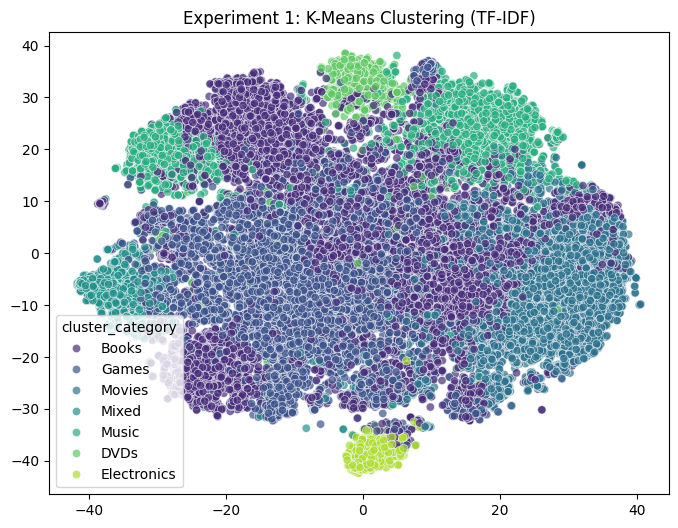

In [28]:
# Run t-SNE on reduced TF-IDF features
plot_tsne(tfidf_matrix_1.toarray(), df["cluster_category"], title="Experiment 1: K-Means Clustering (TF-IDF)")

## Experimet 2: Apply Stemming

In [29]:
df["final_cleaned_reviews_stemmed"] = df["review"].apply(
    lambda x: clean_doc(x, remove_stopwords=True, use_stemming=True, use_lemmatization=False, handle_ec=True, EC_MAPPING=ec_map)
)

In [30]:
vectorizer_stemmed = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix_stemmed = vectorizer_stemmed.fit_transform(df["final_cleaned_reviews_stemmed"])

In [31]:
cluster_labels_stemmed, sil_score_stemmed = kmeans(tfidf_matrix_stemmed, k=10)

# Store the results in the DataFrame
df["cluster_labels_stemmed"] = cluster_labels_stemmed

Silhouette Score for k=10: 0.0076


In [32]:
print("\n Original Clusters (No Stemming):")
print(df["cluster_labels"].value_counts())

print("\n Stemmed Clusters:")
print(df["cluster_labels_stemmed"].value_counts())



 Original Clusters (No Stemming):
cluster_labels
5    9548
0    9001
1    5899
4    2864
9    2444
2    2100
7    1294
8    1269
3     927
6     731
Name: count, dtype: int64

 Stemmed Clusters:
cluster_labels_stemmed
4    13736
1     6722
6     3307
3     3007
9     2519
0     2395
7     1344
8     1325
2      947
5      775
Name: count, dtype: int64


In [33]:
for cluster in sorted(df["cluster_labels_stemmed"].unique()):
    print(f"\n Cluster {cluster} (Stemmed Text):")
    sample_reviews = df[df["cluster_labels_stemmed"] == cluster]["final_cleaned_reviews_stemmed"].sample(5, random_state=42)
    print(sample_reviews.to_string(index=False))



 Cluster 0 (Stemmed Text):
firewir connect mess bought hope would cure bus...
good stuff great product love open capsul morn ...
portabl headphon much say except alreadi work c...
xfile still rock look long time glad find pleas...
great product everyth want reason didnt give st...

 Cluster 1 (Stemmed Text):
amaz grace power movi base true book eyeopen po...
best collect poetri sinc siegel hot afternoon r...
new mysteri writer hit jenni patrict charact be...
love husband use recip book often much misplac ...
five star enough utterli fantast book photograp...

 Cluster 2 (Stemmed Text):
recom dvd bought dvd dispit fact read review ba...
novic taekwondo mani kick escpeci demo circuit ...
dvd work receiv dvd decent amount time wrap app...
bore friend year old daughter bore watch dvd fi...
like advertis okay bought dvd think would one p...

 Cluster 3 (Stemmed Text):
anoth musthav disney book rememb first time saw...
anyon watch movi pyscho watch movi like pyscho ...
fantast love movi las

In [34]:
CLUSTER_NAMES_STEMMED = {
    0: "Mixed",
    1: "Books",
    2: "DVDs",
    3: "Movies",
    4: "Electronics",
    5: "Games",
    6: "Books",
    7: "Movies",
    8: "Electronics",
    9: "Music"
}

df["cluster_category_stemmed"] = df["cluster_labels_stemmed"].map(CLUSTER_NAMES_STEMMED)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


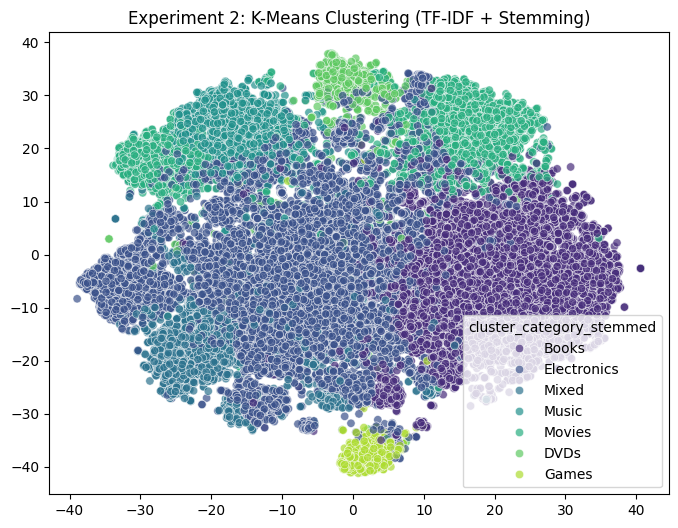

In [35]:
plot_tsne(tfidf_matrix_stemmed.toarray(), df["cluster_category_stemmed"], title="Experiment 2: K-Means Clustering (TF-IDF + Stemming)")


## Experiment 3: Apply Lemming

In [36]:
df["final_cleaned_reviews_lemmed"] = df["review"].apply(
    lambda x: clean_doc(x, remove_stopwords=True, use_stemming=False, use_lemmatization=True, handle_ec=True, EC_MAPPING=ec_map)
)

In [37]:
vectorizer_lemmed = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix_lemmed = vectorizer_lemmed.fit_transform(df["final_cleaned_reviews_lemmed"])

In [38]:
cluster_labels_lemmed, sil_score_lemmed = kmeans(tfidf_matrix_lemmed, k=10)

# Store the results in the DataFrame
df["cluster_labels_lemmed"] = cluster_labels_lemmed

Silhouette Score for k=10: 0.0078


In [39]:
print("\n Stemmed Clusters:")
print(df["cluster_labels_stemmed"].value_counts())

print("\n Lemmed Clusters:")
print(df["cluster_labels_lemmed"].value_counts())


 Stemmed Clusters:
cluster_labels_stemmed
4    13736
1     6722
6     3307
3     3007
9     2519
0     2395
7     1344
8     1325
2      947
5      775
Name: count, dtype: int64

 Lemmed Clusters:
cluster_labels_lemmed
0    13787
2     6577
6     3427
3     2978
4     2471
5     2381
9     1371
8     1351
1      971
7      763
Name: count, dtype: int64


In [40]:
for cluster in sorted(df["cluster_labels_lemmed"].unique()):
    print(f"\n Cluster {cluster} (Lemmed Text):")
    sample_reviews = df[df["cluster_labels_lemmed"] == cluster]["final_cleaned_reviews_lemmed"].sample(5, random_state=42)
    print(sample_reviews.to_string(index=False))


 Cluster 0 (Lemmed Text):
great baby jar avoid banana originally bought y...
single serving butter dish carefully read dimen...
used one time must say really like using produc...
brought back memory soldier day watched sir sir...
good read mother used get better home garden on...

 Cluster 1 (Lemmed Text):
old family favorite family child little saw mov...
wish negative number review one word junki purc...
disappointing big fan looked forward listening ...
dont buy minute dvd wanted get driver ed info y...
bluray poor disapointment movie one favorite bl...

 Cluster 2 (Lemmed Text):
extremely superficial book provides superficial...
worth read book offer pragmatic approach many b...
even close normal brilliance huge dave barry fa...
alternative go penguin guide comprehensive sure...
pulse echo heron nurse echo heron appears read ...

 Cluster 3 (Lemmed Text):
flawed still one best big fan outre movie slew ...
love movie oh god love movie cant wait next sea...
dog flanders borrowed lib

In [41]:
CLUSTER_NAMES_LEMMED = {
    0: "DVDs",
    1: "Books",
    2: "CDs",
    3: "Mixed Topics",
    4: "Games",
    5: "Electonics",
    6: "Books",
    7: "Mixed Topics",
    8: "Music",
    9: "Movies"
    }

df["cluster_category_lemmed"] = df["cluster_labels_lemmed"].map(CLUSTER_NAMES_LEMMED)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


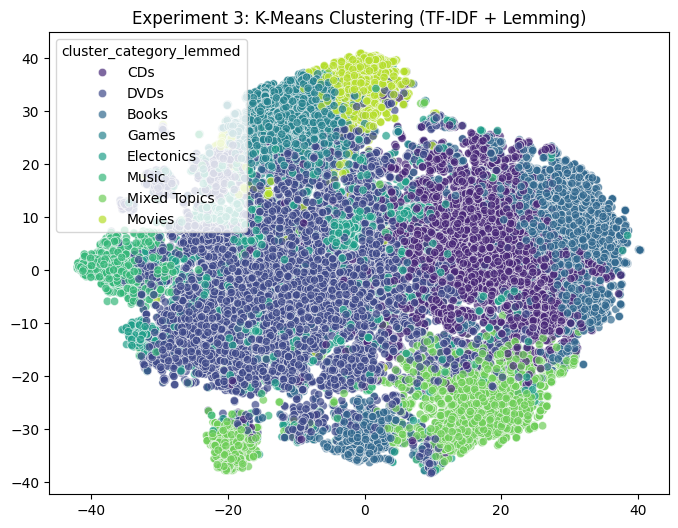

In [42]:
plot_tsne(tfidf_matrix_lemmed.toarray(), df["cluster_category_lemmed"], title="Experiment 3: K-Means Clustering (TF-IDF + Lemming)")

-----------------------------------------------------------------

## Update EC Mappings

In [43]:
# Redefine categories and their seed words
CATEGORIES = {
    "book": [
        "book", "novel", "story", "literature", "biography", "author", "hardcover", "paperback",
        "fiction", "nonfiction", "bestseller", "reading", "poetry", "autobiography", "manuscript",
        "graphic novel", "ebook", "textbook", "publication", "volume", "saga", "classic", "narrative"
    ],
    "movie": [
        "movie", "film", "cinema", "screenplay", "director", "actor", "actress", "theater", "tv", "series",
        "show", "screen", "hollywood", "blockbuster", "soundtrack", "sequel", "prequel", "box office",
        "documentary", "short film", "animation", "feature film", "DVD"
    ],
    "music": [
        "music", "album", "song", "track", "tune", "band", "concert", "melody", "symphony", "soundtrack",
        "record", "playlist", "vinyl", "guitar", "piano", "orchestra", "dj", "single", "mixtape",
        "acoustic", "karaoke", "instrumental", "festival", "CD", "cassette", "tape"
    ],
    "game": [
        "game", "gaming", "video game", "console", "playstation", "xbox", "nintendo", "pc", "joystick",
        "esports", "multiplayer", "strategy", "rpg", "fps", "arcade", "gamers", "tournament", "quest",
        "leaderboard", "controller", "virtual reality", "board game", "card game", "dice game", "dice"
    ],
    "electronics": [
        "electronics", "laptop", "computer", "tablet", "phone", "mobile", "smartphone", "monitor",
        "camera", "battery", "processor", "gadget", "device", "smartwatch", "charger", "keyboard",
        "headphones", "bluetooth", "screen", "hardware", "usb", "wearable", "router", "motherboard"]
}

In [44]:
EC_MAPPING = ec_mapping(df, "cleaned_reviews")

Generated EC Mapping from cleaned_reviews: {'volume': 'book', 'tape': 'music', 'book': 'book', 'reading': 'book', 'movie': 'movie', 'vinyl': 'music', 'album': 'music', 'record': 'music', 'song': 'music', 'music': 'music'}


<ipython-input-17-edc1e9232d70>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[text_column].fillna("", inplace=True)


## Experiment 4: Different K Sizes

### K = 5

In [45]:
df["final_cleaned_reviews_k5"] = df["review"].apply(
    lambda x: clean_doc(x, remove_stopwords=True, use_stemming=False, use_lemmatization=True, handle_ec=True, EC_MAPPING=EC_MAPPING)
)

In [46]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix_k5 = vectorizer.fit_transform(df["final_cleaned_reviews_k5"])

In [47]:
kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10)
tfidf_labels_5 = kmeans_5.fit_predict(tfidf_matrix_k5)

In [48]:
df["cluster_labels_tfidf_5"] = tfidf_labels_5

In [49]:
# Compute Silhouette Score for TF-IDF clustering with k=5
sil_score_tfidf_5 = silhouette_score(tfidf_matrix_k5, tfidf_labels_5)
print(f"Silhouette Score (TF-IDF, k=5): {sil_score_tfidf_5:.4f}")

Silhouette Score (TF-IDF, k=5): 0.0115


In [50]:
for cluster in sorted(df["cluster_labels_tfidf_5"].unique()):
    print(f"\n Cluster {cluster} (With k=5):")
    sample_reviews = df[df["cluster_labels_tfidf_5"] == cluster]["final_cleaned_reviews"].sample(6, random_state=42)
    print(sample_reviews.to_string(index=False))


 Cluster 0 (With k=5):
waste time messages parker brothers game teachi...
loved loved game never got boring really cool g...
disgrace harry potter games im sorry really lik...
great game bought jak yesterday already love th...
cheap worked great first games within month alr...
game like playing terribly made bootleg copy ca...

 Cluster 1 (With k=5):
awesome read wages sin awesome read book captur...
book shuld place fiction category hard get book...
boring boring boring book doesnt seem go anywhe...
keeps laughing book mia thermopolis regular gir...
disappointedthank goodness library lets frank b...
tab tiny tablature book small crammed beside no...

 Cluster 2 (With k=5):
nice look poor quality triangle looks real nice...
dont buy tracks cd worth listening even dont br...
thing large got dry sweaters hanging shower cur...
ways improve lifestory mountain finished book s...
dont buy darth vader pinata pinata broke first ...
thing leaks agree posters leakage high hopes bc...

 Cluster 

In [51]:
CLUSTER_NAMES_5 = {
    0: "Games",
    1: "Books",
    2: "Mixed",
    3: "Movies",
    4: "Music",
}

df["cluster_labels_tfidf_5"] = df["cluster_labels_tfidf_5"].map(CLUSTER_NAMES_5)

### k = 8

In [52]:
df["final_cleaned_reviews_k8"] = df["review"].apply(
    lambda x: clean_doc(x, remove_stopwords=True, use_stemming=False, use_lemmatization=True, handle_ec=True, EC_MAPPING=EC_MAPPING)
)

In [53]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix_k8 = vectorizer.fit_transform(df["final_cleaned_reviews_k8"])

In [54]:
kmeans_8 = KMeans(n_clusters=8, random_state=42, n_init=10)
tfidf_labels_8 = kmeans_8.fit_predict(tfidf_matrix_k8)

In [55]:
df["cluster_labels_tfidf_8"] = tfidf_labels_8

In [56]:
# Compute Silhouette Score for TF-IDF clustering with k=8
sil_score_tfidf_8 = silhouette_score(tfidf_matrix_k8, tfidf_labels_8)
print(f"Silhouette Score (TF-IDF, k=8): {sil_score_tfidf_8:.4f}")

Silhouette Score (TF-IDF, k=8): 0.0110


In [57]:
for cluster in sorted(df["cluster_labels_tfidf_8"].unique()):
    print(f"\n Cluster {cluster} (With k=8):")
    sample_reviews = df[df["cluster_labels_tfidf_8"] == cluster]["final_cleaned_reviews"].sample(6, random_state=42)
    print(sample_reviews.to_string(index=False))


 Cluster 0 (With k=8):
boring expected lot cd let agree review said pa...
love like funky house cd enjoy listening work g...
im fan would five star review many original son...
terrible sound agree reviewer content cd sound ...
cd sick man cd tight especiall beat get u danci...
ho hum next starting first music cd never seems...

 Cluster 1 (With k=8):
broke received core flex gym starting putting t...
english myster fan nice watch english mystery d...
french fry cutter weak progressive internationa...
baby wont take bottle heard great things avent ...
dont buy sophisticated graphics needs heres wha...
exceptionally absorbing emotional journey among...

 Cluster 2 (With k=8):
shes nutbut colorful genuine nut nellie mckayth...
id give stars option weve dvd player years past...
worst dvd ever seen agree previous reviewer wor...
wont burn dvds spent great deal time working pr...
pay item rating thought paying dvd okaythis fre...
great show great dvd really good sound picture ...

 Cluster 

In [58]:
CLUSTER_NAMES_k8 = {
    0: "Music",
    1: "Books",
    2: "Mixed",
    3: "Movies",
    4: "Mixed",
    5: "Electronics",
    6: "Games",
    7: "Movies",
}
df["cluster_labels_tfidf_8"] = df["cluster_labels_tfidf_8"].map(CLUSTER_NAMES_k8)

In [59]:
print("\n Clusters With K=5:")
print(df["cluster_labels_tfidf_5"].value_counts())

print("\n Clusters With K=8:")
print(df["cluster_labels_tfidf_8"].value_counts())



 Clusters With K=5:
cluster_labels_tfidf_5
Mixed     20297
Books      7860
Music      3743
Movies     3393
Games       784
Name: count, dtype: int64

 Clusters With K=8:
cluster_labels_tfidf_8
Books          16420
Games           7357
Mixed           4599
Movies          3802
Electronics     2517
Music           1382
Name: count, dtype: int64


### T-SNE

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


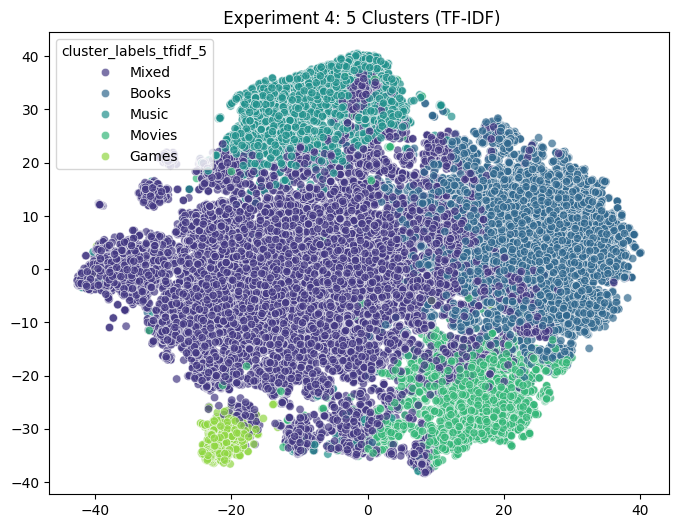

In [60]:
# t-sne plot
plot_tsne(tfidf_matrix_k5.toarray(), df["cluster_labels_tfidf_5"], title=" Experiment 4: 5 Clusters (TF-IDF)")

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


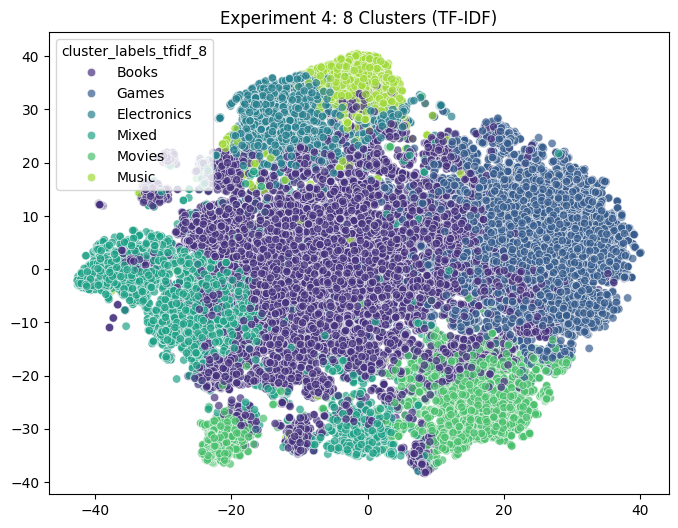

In [61]:
# t-sne plot
plot_tsne(tfidf_matrix_k8.toarray(), df["cluster_labels_tfidf_8"], title="Experiment 4: 8 Clusters (TF-IDF)")

## Experiement 5: Word2Vec Embedding

In [62]:
df["cleaned_reviews_w2v"] = df["review"].apply(lambda x: clean_doc(x, remove_stopwords=True, use_stemming=False, use_lemmatization=False, handle_ec=True, EC_MAPPING=EC_MAPPING))

In [63]:
# Get Word2Vec embeddings for each review
def get_word2vec_vector(words):

    word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]

    # If no vectors are found, return a zero vector (for out-of-vocabulary words)
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(word2vec_model.vector_size)

In [64]:
# Tokenize the text
tokenized_texts_5 = df["cleaned_reviews_w2v"].apply(lambda x: x.split())  # Tokenize reviews

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_texts_5, vector_size=100, window=5, min_count=2, workers=4)

# Apply this function to get vectors for each review
word2vec_vectors = np.array([get_word2vec_vector(words) for words in tokenized_texts_5])


In [65]:
# Run K-Means clustering on Word2Vec vectors (K=5)
kmeans_ex5 = KMeans(n_clusters=5, random_state=42, n_init=10)
word2vec_labels_ex5 = kmeans_ex5.fit_predict(word2vec_vectors)

# Add the cluster labels to the DataFrame
df["cluster_labels_word2vec"] = word2vec_labels_ex5


In [66]:
# Compute Silhouette Score for word2vec clustering with k=5
sil_score_word2vec_5 = silhouette_score(word2vec_vectors, word2vec_labels_ex5)
print(f"Silhouette Score (Word2Vec, k=5): {sil_score_word2vec_5:.4f}")

Silhouette Score (Word2Vec, k=5): 0.1409


In [67]:
for cluster in sorted(df["cluster_labels_word2vec"].unique()):
    print(f"\n Cluster {cluster} (With w2v):")
    sample_reviews = df[df["cluster_labels_word2vec"] == cluster]["final_cleaned_reviews"].sample(6, random_state=42)
    print(sample_reviews.to_string(index=False))


 Cluster 0 (With w2v):
happened korn happened remeber good old days ko...
ouch star high rating turkey mr clapton anythin...
inconsistent schlock know ctds supposed light h...
pretty good got cd one music thing pleasantly s...
ahahh sucks haha bad listened really didnt hear...
wonderful lyricist musician bought cd whim like...

 Cluster 1 (With w2v):
love condescension one thing turn form instruct...
sordid del shores may geniusthis movie fun funn...
good movie must see saw today blown away leos e...
disappointing really found movie boring actors ...
best show ever best movie tv actors great book ...
call itit cant call understand people like movi...

 Cluster 2 (With w2v):
leaves soapy streaks clothes live apartment lac...
impressed first introducing bottle week old tri...
left stranded months product cheapest pump coul...
package received broken looks liked used one re...
good concept faulty zipper bought protect brita...
puppy likes siberian husky puppy really likes t...

 Cluster 

In [68]:
CLUSTER_NAMES_w2v = {
    0: "Movies",
    1: "Books",
    2: "Music",
    3: "Mixed",
    4: "Electronics",
}

df["cluster_category_w2v"] = df["cluster_labels_word2vec"].map(CLUSTER_NAMES_w2v)

In [69]:
print("\n Clusters Word2Vec + k=5:")
print(df["cluster_category_w2v"].value_counts())


 Clusters Word2Vec + k=5:
cluster_category_w2v
Music          13050
Electronics     7253
Mixed           5998
Books           5278
Movies          4498
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


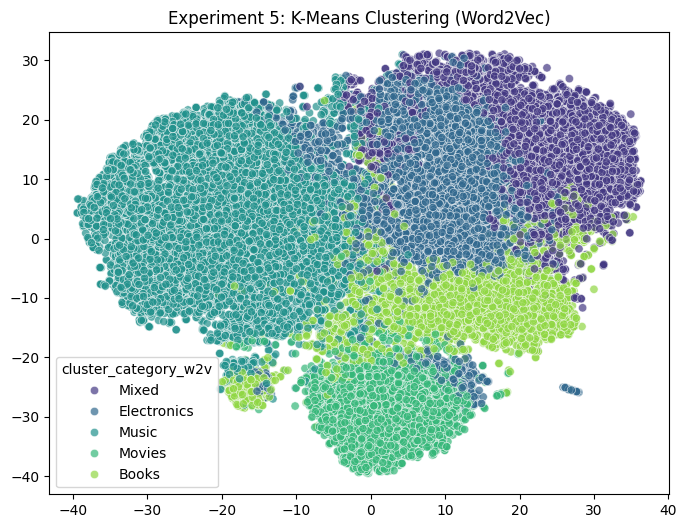

In [70]:
plot_tsne(word2vec_vectors, df["cluster_category_w2v"], title="Experiment 5: K-Means Clustering (Word2Vec)")


## Experiment 6: Mesure the Effects of ECs

In [71]:
# Tokenize text
tokenized_texts_6 = df["review"].apply(lambda x: x.split())

# Train Word2Vec
word2vec_model_6 = Word2Vec(sentences=tokenized_texts_6, vector_size=100, window=5, min_count=2, workers=4)

# Function to find most similar words
def get_similar_words(word, top_n=5):
    if word in word2vec_model_6.wv:
        return [w for w, _ in word2vec_model_6.wv.most_similar(word, topn=top_n)]
    return []


In [72]:
# Expand equivalence classes using Word2Vec
auto_ec_mapping = defaultdict(set)

for category, seed_words in CATEGORIES.items():
    for word in seed_words:
        similar_words = get_similar_words(word, top_n=5)  # Get top 5 similar words
        auto_ec_mapping[category].update(similar_words)

# Convert to a dictionary
auto_ec_mapping = {k: list(v) for k, v in auto_ec_mapping.items()}
print(" Auto-Generated Equivalence Classes:", auto_ec_mapping)


 Auto-Generated Equivalence Classes: {'book': ['Comfort', 'mystical', 'story', 'brilliant', 'April', 'calculator', 'musical', 'Beneath', 'NIS', 'creating', '(sorry', 'Cop', 'keyboard', 'drama', 'scale', 'Gods', 'range:', 'screen', 'unsatisfying', 'appearance', 'remote', 'personality', 'remarkable', 'June', 'character', 'leadership', 'military', 'writings', 'plot', 'exploration', 'fantasy', 'Continuing', 'portable,', 'trunk', 'must-read', 'adaptation', 'fantastically', 'adventures', 'Death', 'novel.', 'misunderstanding', 'film', 'memoir', 'enduring', 'Hunt', 'prose', 'careless', 'anodized', 'Mr.', 'synopsis', 'collection', 'Alison', 'Karajan', 'apt', 'novel', 'blender', 'review', 'historical', 'January', 'science', 'backpack', 'Disappointing', 'motor.', 'writing', 'creation', 'honesty', 'seeing', 'Important', 'Franchise', 'Bible:', 'romance', 'Pierce', 'threat', 'cosmetic.', 'characters', 'read', 'anthropological', 'artistic', 'Novel', 'Steel', 'book', 'books', 'classic:', 'thriller', '

In [73]:
def apply_auto_ec_mapping(text):
    words = text.split()
    new_words = []

    for word in words:
        found = False
        for category, ec_words in auto_ec_mapping.items():
            if word in ec_words:
                new_words.append(category)  # Replace word with category name
                found = True
                break
        if not found:
            new_words.append(word)  # Keep original word if no EC match

    return " ".join(new_words)

In [74]:
# Apply mapping to reviews
df["final_cleaned_reviews_with_auto_ec"] = df["final_cleaned_reviews"].apply(apply_auto_ec_mapping)

# Compare before/after
print(df[["final_cleaned_reviews", "final_cleaned_reviews_with_auto_ec"]].sample(10))


                                   final_cleaned_reviews  \
1751   athere thiss book needs wake book tring put us...   
17339  oh old mouli grater difficult hold clean use w...   
12205  organized poorly questions realistic either re...   
31738  tiresome unfunny typical never found writer la...   
18887  ohhhh found excellent product long lonely nigh...   
23103  good san andreas grand theft auto keeps churni...   
7748   worked perfect adt alarm sensor replacement ha...   
25151  dem bones dem bones books like fun buttaking e...   
13381  first book chess almost made quit first introd...   
32639  good strut tool tool worked great removing rei...   

                      final_cleaned_reviews_with_auto_ec  
1751   athere thiss book needs wake book tring put us...  
17339  oh old mouli grater difficult hold clean use w...  
12205  organized poorly questions realistic either bo...  
31738  tiresome unfunny typical never found writer la...  
18887  ohhhh found excellent product long lo

### KMeans

In [75]:
# Tokenize text with auto-EC mapping
tokenized_texts_auto_ec = df["final_cleaned_reviews_with_auto_ec"].apply(lambda x: x.split())

# Train Word2Vec on EC Mapped Text
word2vec_auto_ec = Word2Vec(sentences=tokenized_texts_auto_ec, vector_size=100, window=5, min_count=2, workers=4)

word2vec_vectors_auto_ec = np.array([
    get_word2vec_vector(words) for words in tokenized_texts_auto_ec
])

# Run K-Means Clustering
kmeans_auto_ec = KMeans(n_clusters=5, random_state=42, n_init=10)
df["cluster_labels_auto_ec"] = kmeans_auto_ec.fit_predict(word2vec_vectors_auto_ec)

In [76]:
for cluster in sorted(df["cluster_labels_auto_ec"].unique()):
    print(f"\n Cluster {cluster} (With w2v):")
    sample_reviews = df[df["cluster_labels_auto_ec"] == cluster]["final_cleaned_reviews"].sample(6, random_state=42)
    print(sample_reviews.to_string(index=False))


 Cluster 0 (With w2v):
finally america ive seen japanese version movie...
great christmas time youre mood relax watch wel...
timeless treasure lovers trobisch find dream fu...
smear radical right wing nuts great diversion r...
thought dj sasha got hosed one line thought new...
truly disappointing amazed people raved cookboo...

 Cluster 1 (With w2v):
good far best tasting energy drink dont care ta...
good stuff nice cd reasonably priced since read...
huge disappointment bought brand new nieces bir...
dont buy would recommend anyone doesnt well plu...
watercolor techniques receive book several week...
low quality price paper sold price amazon local...

 Cluster 2 (With w2v):
shabby didnt buy cd jacked sister whos little p...
snooze fest suffer insomniathen watch moviei wa...
less talk action dvd finally arrived workout go...
beatufil well done enjoyed wonderful movie gosp...
solid performance enjoyed movie dealt difficult...
giver review would tell people book bc good boo...

 Cluster 

In [77]:
CLUSTER_NAMES_w2v_autoec = {
    0: "Music",
    1: "Mixed",
    2: "Books",
    3: "Movies",
    4: "Electronics",
}

df["cluster_labels_auto_ec"] = df["cluster_labels_auto_ec"].map(CLUSTER_NAMES_w2v_autoec)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


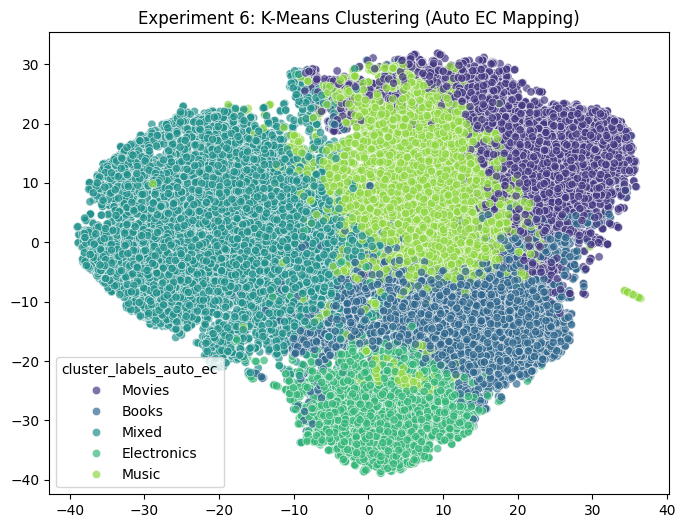

In [78]:
# Run t-SNE to visualize clusters
plot_tsne(word2vec_vectors_auto_ec, df["cluster_labels_auto_ec"], title="Experiment 6: K-Means Clustering (Auto EC Mapping)")

In [79]:
# Compute Silhouette Score for word2vec clustering
sil_score_word2vec_auto_ec = silhouette_score(word2vec_vectors_auto_ec, df["cluster_labels_auto_ec"])

print(f"Silhouette Score (Word2Vec, Dynamic EC Mapping): {sil_score_word2vec_auto_ec:.4f}")

Silhouette Score (Word2Vec, Dynamic EC Mapping): 0.1353


In [80]:
# Category Counts
print("\n Clusters Word2Vec + k=5 + Auto EC Mapping:")
print(df["cluster_labels_auto_ec"].value_counts())



 Clusters Word2Vec + k=5 + Auto EC Mapping:
cluster_labels_auto_ec
Mixed          12707
Music           7471
Movies          5961
Books           5649
Electronics     4289
Name: count, dtype: int64


## Experiment 7: Topic Modeling with LDA

In [81]:
# Use CountVectorizer instead of TF-IDF (LDA requires raw counts)
vectorizer = CountVectorizer(max_features=5000, stop_words='english')

# LDA assumes word occurrence (not frequency importance like TF-IDF) represents topics.
bow_matrix = vectorizer.fit_transform(df["final_cleaned_reviews_with_auto_ec"])

# Extract feature names (words)
feature_names = vectorizer.get_feature_names_out()

In [82]:
# Train LDA with 10 topics
lda_model_7 = LatentDirichletAllocation(n_components=10, random_state=42)
lda_matrix_7 = lda_model_7.fit_transform(bow_matrix)

In [83]:
def get_lda_topics(model, feature_names, top_n=5):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-top_n - 1:-1]]
        topics[topic_idx] = ", ".join(top_words)
    return topics

lda_topics_7 = get_lda_topics(lda_model_7, feature_names)

# Print topic labels
for topic, words in lda_topics_7.items():
    print(f" Topic {topic}: {words}")


 Topic 0: music, movie, like, good, great
 Topic 1: music, movie, version, great, sound
 Topic 2: money, dont, amazon, buy, waste
 Topic 3: electronics, great, use, work, works
 Topic 4: electronics, product, great, use, fit
 Topic 5: great, love, old, like, kids
 Topic 6: book, good, information, great, movie
 Topic 7: book, like, good, time, life
 Topic 8: movie, book, like, good, great
 Topic 9: like, good, product, use, great


In [84]:
# Assign the most likely topic to each review
df["lda_topic_7"] = lda_matrix_7.argmax(axis=1)

# Map topics to labels for easier interpretation
topic_labels_7 = {idx: topic for idx, topic in lda_topics_7.items()}
df["lda_topic_label-7"] = df["lda_topic_7"].map(topic_labels_7)

# Print sample reviews with assigned topics
print(df[["final_cleaned_reviews_with_auto_ec", "lda_topic_label-7"]].sample(10))


                      final_cleaned_reviews_with_auto_ec  \
23549  easiest way learn perspective book excellent s...   
23428  aboard murder entry jessica fletcher book enjo...   
7776   pippi makes kids say yippie kids love movie di...   
2208   amazon shipping horribly slow preordered movie...   
20285  must factory heads ever attended sound factory...   
3952   best movie year title pretty much says loved m...   
17133  disney wrost movie bother making sequal movie ...   
17713  buy product technical person teach photoshop p...   
24688  dont buy ordered got gun instead hoping would ...   
18537  great music andys music heart fantastic part p...   

                           lda_topic_label-7  
23549  book, good, information, great, movie  
23428           book, like, good, time, life  
7776            great, love, old, like, kids  
2208         money, dont, amazon, buy, waste  
20285        money, dont, amazon, buy, waste  
3952          movie, book, like, good, great  
17133     

In [85]:
comparison_table = pd.crosstab(df["lda_topic_label-7"], df["cluster_labels_auto_ec"])

print(comparison_table)

cluster_labels_auto_ec                 Books  Electronics  Mixed  Movies  \
lda_topic_label-7                                                          
book, good, information, great, movie     45            4    132    1399   
book, like, good, time, life             329           22     20    4166   
electronics, great, use, work, works      52           30   3424       4   
electronics, product, great, use, fit     17            7   2349      13   
great, love, old, like, kids             351           74    881     146   
like, good, product, use, great           82           29   3249      12   
money, dont, amazon, buy, waste          363           33   2445      72   
movie, book, like, good, great          3778          118     83     130   
music, movie, like, good, great          408         3373     51      13   
music, movie, version, great, sound      224          599     73       6   

cluster_labels_auto_ec                 Music  
lda_topic_label-7                       

In [86]:
def plot_tsne_lda(data, labels, title="t-SNE Clustering Visualization"):

    n_components_pca = min(10, data.shape[1])  # Limit to 10 or data's features
    pca = PCA(n_components=n_components_pca, random_state=42)
    reduced_data = pca.fit_transform(data)

    # Run t-SNE on reduced data
    reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
    embedding = reducer.fit_transform(reduced_data)

    # Plot results
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette="viridis", alpha=0.7)
    plt.title(title)
    plt.show()

In [87]:
# Set the number of clusters equal to the number of topics
n_topics = lda_matrix_7.shape[1]

# Cluster LDA topic distributions using K-Means
kmeans = KMeans(n_clusters=n_topics, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(lda_matrix_7)

In [88]:
# Compute Silhouette Score using Euclidean distance
silhouette_7 = silhouette_score(lda_matrix_7, kmeans_labels)
print(f"Silhouette Score (LDA): {silhouette_7:.4f}")

Silhouette Score (LDA): 0.4534


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


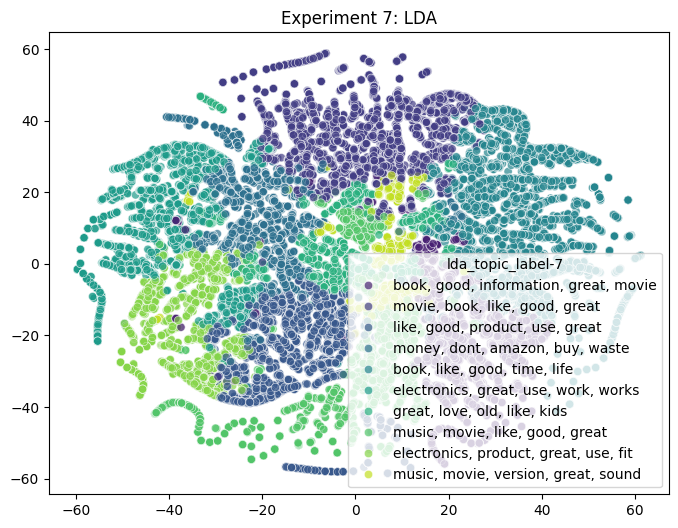

In [89]:
plot_tsne_lda(lda_matrix_7, df["lda_topic_label-7"], title="Experiment 7: LDA")

## Find the Best Number of Topics

In [90]:
def compute_perplexity(n_topics_range):
    scores = []
    for n in n_topics_range:
        lda = LatentDirichletAllocation(n_components=n, random_state=42)
        lda.fit(bow_matrix)
        scores.append((n, lda.perplexity(bow_matrix)))
    return scores

# Try different numbers of topics and pick the best
topic_scores = compute_perplexity(range(5, 10))  # Test topics from 5 - 9
best_n = sorted(topic_scores, key=lambda x: x[1])[0][0]  # lowest perplexity score

print(f" Optimal number of topics: {best_n}")


 Optimal number of topics: 9


In [91]:
# Print the Perplexity Score
for n, perplexity in topic_scores:
    print(f"Number of Topics: {n}, Perplexity Score: {perplexity:.2f}")

Number of Topics: 5, Perplexity Score: 1236.32
Number of Topics: 6, Perplexity Score: 1219.03
Number of Topics: 7, Perplexity Score: 1234.21
Number of Topics: 8, Perplexity Score: 1231.55
Number of Topics: 9, Perplexity Score: 1205.25


In [92]:
# Train LDA again with the best number of topics
lda_model_8 = LatentDirichletAllocation(n_components=best_n, random_state=42)
lda_matrix_8 = lda_model_8.fit_transform(bow_matrix)

# Extract topics
lda_topics_8 = get_lda_topics(lda_model_8, feature_names, top_n=5)

# Print new topic labels
for topic, words in lda_topics_8.items():
    print(f" Topic {topic}: {words}")


 Topic 0: music, movie, like, good, great
 Topic 1: movie, music, version, original, great
 Topic 2: money, product, dont, amazon, buy
 Topic 3: electronics, great, use, work, works
 Topic 4: electronics, use, product, great, good
 Topic 5: great, like, love, old, good
 Topic 6: book, good, information, great, movie
 Topic 7: book, like, good, time, life
 Topic 8: movie, book, like, good, great


In [93]:
# Update lda_topic and lda_topic_label columns
df["lda_topic_8"] = lda_matrix_8.argmax(axis=1)
topic_labels_8 = {idx: topic for idx, topic in lda_topics_8.items()}
df["lda_topic_label_8"] = df["lda_topic_8"].map(topic_labels_8)

In [94]:
comparison_table = pd.crosstab(df["lda_topic_label_8"], df["cluster_labels_auto_ec"])
print(comparison_table)

cluster_labels_auto_ec                  Books  Electronics  Mixed  Movies  \
lda_topic_label_8                                                           
book, good, information, great, movie      44            5    134    1325   
book, like, good, time, life              307           24     15    4252   
electronics, great, use, work, works       69           35   3461       2   
electronics, use, product, great, good     33           16   4430       8   
great, like, love, old, good              328           77   1641     123   
money, product, dont, amazon, buy         334           35   2803      82   
movie, book, like, good, great           3930          128     86     147   
movie, music, version, original, great    205          373     87       8   
music, movie, like, good, great           399         3596     50      14   

cluster_labels_auto_ec                  Music  
lda_topic_label_8                              
book, good, information, great, movie    2040  
book, li

## Experiment 8: Compare LDA with Best Cluster

In [95]:
# # Extract top words for each topic
lda_topics = get_lda_topics(lda_model_8, feature_names, top_n=5)

# Print topic labels
for topic, words in lda_topics.items():
    print(f" Topic {topic}: {words}")


 Topic 0: music, movie, like, good, great
 Topic 1: movie, music, version, original, great
 Topic 2: money, product, dont, amazon, buy
 Topic 3: electronics, great, use, work, works
 Topic 4: electronics, use, product, great, good
 Topic 5: great, like, love, old, good
 Topic 6: book, good, information, great, movie
 Topic 7: book, like, good, time, life
 Topic 8: movie, book, like, good, great


In [96]:
df["lda_topic"] = lda_matrix_8.argmax(axis=1)

# Map topics to labels for better interpretation
topic_labels = {idx: topic for idx, topic in lda_topics.items()}
df["lda_topic_label"] = df["lda_topic"].map(topic_labels)

# Print some sample reviews with assigned topics
print(df[["final_cleaned_reviews_with_auto_ec", "lda_topic_label"]].sample(10))


                      final_cleaned_reviews_with_auto_ec  \
8045   happy yes bounces yes difficult set however us...   
30152  two tracks worth cost sensible darina two grea...   
20942  dangerous careful movie tore calf muscle movie...   
6290   full movie book actually really enjoyed movie ...   
2918   major disappointment looked forward movie past...   
30029  anything ricky gervais excellent last episode ...   
19700  good great oscar getting old reflected movie b...   
28352  exellent introduction almost prerequisites nee...   
17586  book instructions carefully horrible time gett...   
34905  ear cups fall apart regular use initial sound ...   

                              lda_topic_label  
8045   electronics, use, product, great, good  
30152         music, movie, like, good, great  
20942  electronics, use, product, great, good  
6290             book, like, good, time, life  
2918           movie, book, like, good, great  
30029          movie, book, like, good, great  
197

In [97]:
comparison_table = pd.crosstab(df["lda_topic_label"], df["cluster_labels_auto_ec"])
print(comparison_table)


cluster_labels_auto_ec                  Books  Electronics  Mixed  Movies  \
lda_topic_label                                                             
book, good, information, great, movie      44            5    134    1325   
book, like, good, time, life              307           24     15    4252   
electronics, great, use, work, works       69           35   3461       2   
electronics, use, product, great, good     33           16   4430       8   
great, like, love, old, good              328           77   1641     123   
money, product, dont, amazon, buy         334           35   2803      82   
movie, book, like, good, great           3930          128     86     147   
movie, music, version, original, great    205          373     87       8   
music, movie, like, good, great           399         3596     50      14   

cluster_labels_auto_ec                  Music  
lda_topic_label                                
book, good, information, great, movie    2040  
book, li

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


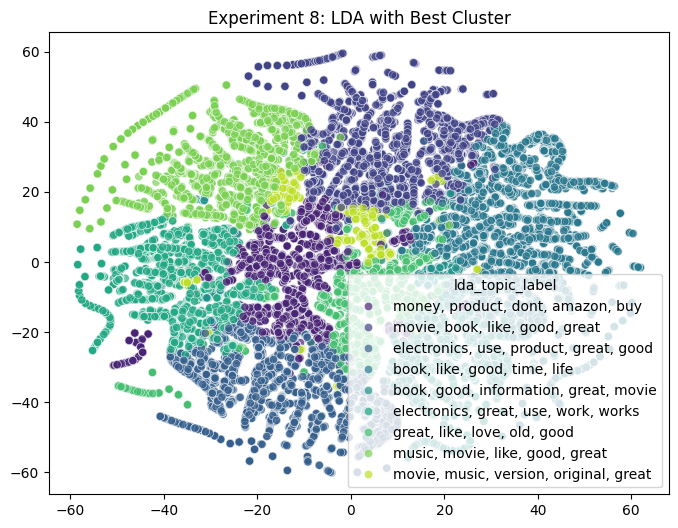

In [98]:
plot_tsne_lda(lda_matrix_8, df["lda_topic_label"], title="Experiment 8: LDA with Best Cluster")

In [99]:
# Calculate the score
silhouette_kmeans_8 = silhouette_score(lda_matrix_8, kmeans_labels)
print(f"Silhouette Score (LDA + K-Means): {silhouette_kmeans_8:.4f}")

Silhouette Score (LDA + K-Means): 0.3336
